In [1]:
import os
import numpy as np
import csv
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import math


### Load data 

In [2]:

## import data
df = pd.read_csv('DATA.csv', parse_dates=['Date'])
print(df.head())
print(df.tail())
print(df.shape)
print(df.columns)

        Date      Open      High       Low     Close      Volume      NASDAQ   \
0 2010-07-01  9.082143  9.100000  8.686429  8.874286  1022896000  2101.360107   
1 2010-07-02  8.946072  8.961785  8.685715  8.819285   693842800  2091.790039   
2 2010-07-06  8.964286  9.028571  8.791429  8.879642   615235600  2093.879883   
3 2010-07-07  8.946072  9.241786  8.919642  9.238214   654556000  2159.469971   
4 2010-07-08  9.374286  9.389286  9.103214  9.217500   738144400  2175.399902   

         NYSE       S&P 500  FTSE100  ...  RUSSELL2000    HENG SENG  \
0  6462.029785  1027.369995  4805.75  ...   604.760010          NaN   
1  6434.810059  1022.580017  4838.09  ...   598.969971  19905.32031   
2  6486.089844  1028.060059  4965.00  ...   590.030029  20084.11914   
3  6685.779785  1060.270020  5014.82  ...   611.659973  19857.07031   
4  6755.810059  1070.250000  5105.45  ...   620.270020  20050.56055   

           SSE  Crude Oil         Gold        VIX  USD index      Amazon  \
0  2373.79

### Create Apple stock price plot
Apple stock price plot used to compare the future stock prediction with it

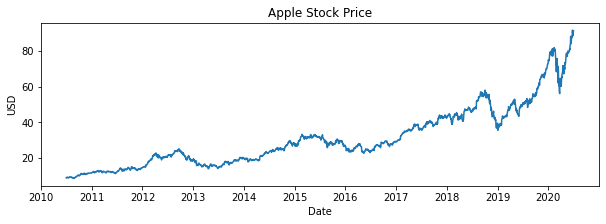

In [3]:
## https://www.earthdatascience.org/courses/use-data-open-source-python/use-time-series-data-in-python/date-time-types-in-pandas-python/customize-dates-matplotlib-plots-python/
fig, ax = plt.subplots(figsize=(10,3))
ax.plot(df['Date'], df['Close'], label='Apple stock')
ax.set(xlabel="Date",
       ylabel="USD",
       title="Apple Stock Price")
date_form = DateFormatter("%Y")
ax.xaxis.set_major_formatter(date_form)
plt.show()

### Calculate technical indicators

**List of technical indicators and explanation:**


**1.   Bollinger bands: Bollinger Bands is used to define the prevailing high and low prices in a market to characterize the trading band of a financial instrument or commodity. Bollinger Bands are a volatility indicator. Bands are consists of Moving Average (MA) line, a upper band and lower band. The upper and lower bands are simply MA adding and subtracting standard deviation.** 

**2.   EMA: Exponential moving average is a better version of a simple moving average that doesnt have SMAs lag. Moving averages just average out the data for a given time so we know how the company's closing price are trending for a given amount of days. example for 4 days is price was 22,23 ,45,1**
**(the company crashed on 4th day) the average would be 23. Now 23 is a below average value so it gives us an idea that 45 was indeed just a fluke and that infact the company was always making losses**
**EMA is calculated as:**
**EMA(t)EMA(t0)=(1−α)EMA(t−1)+α p(t)=p(t0)**
**where** 
**α=1L+1 and length of window is α=2M+1**
**I used the ewm(exponential weighted mean ) function to calculate ema.**



**3. Momentum: Momentum is perhaps the simplest and easiest oscillator (financial analysis tool) to understand and use. It is the measurement of the speed or velocity of price changes, or the rate of change in price movement for a particular asset.**

**The formula for momentum is:**

**Momentum=V−Vx**
**where:**

**V=Latest price**

**Vx=Closing price**

**x=Number of days ago**


**Other features calculated are**
**moving averages of 7 and 21 days and standard deviation.**


**Great Links are:**
1. https://www.learndatasci.com/tutorials/python-finance-part-3-moving-average-trading-strategy/
2. https://towardsdatascience.com/trading-technical-analysis-with-pandas-43e737a17861

In [4]:

def get_technical_indicators(data):
    # Create 7 and 21 days Moving Average
    data['MA7'] = data.iloc[:,4].rolling(window=7).mean()
    data['MA21'] = data.iloc[:,4].rolling(window=21).mean()

    # Create MACD
    data['MACD'] = data.iloc[:,4].ewm(span=26).mean() - data.iloc[:,1].ewm(span=12,adjust=False).mean()

    # Create Bollinger Bands
    data['20SD'] = data.iloc[:, 4].rolling(20).std()
    data['upper_band'] = data['MA21'] + (data['20SD'] * 2)
    data['lower_band'] = data['MA21'] - (data['20SD'] * 2)

    # Create Exponential moving average
    data['EMA'] = data.iloc[:,4].ewm(com=0.5).mean()

    # Create LogMomentum
    data['logmomentum'] = np.log(data.iloc[:,4] - 1)

    return data
T_df = get_technical_indicators(df)

In [5]:
#For doing the fourier
dataset = T_df.iloc[20:,:].reset_index(drop=True)


###  Fourier transform features

**Fourier Transform uses many spectral components to try and train data. From time domain its converted to frequency domain and then calculated. After that it's reconverted into time domain where it's plotted.**
**Fourier Transform as indicator helps to extract predominate cycle from a series of data**

**Reference: https://www.metastock.com/customer/resources/taaz/?p=58**

**In the above example we can see the spectral component of 100 is closest to the real price so we will move ahead ith 100**




In [6]:
#Getting the Fourier transform features
def get_fourier_transfer(dataset):
    # Get the columns for doing fourier
    data_FT = dataset[['Date', 'Close']]

    close_fft = np.fft.fft(np.asarray(data_FT['Close'].tolist()))
    fft_df = pd.DataFrame({'fft': close_fft})
    fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
    fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))

    fft_list = np.asarray(fft_df['fft'].tolist())
    fft_com_df = pd.DataFrame()
    for num_ in [3, 6, 9]:
        fft_list_m10 = np.copy(fft_list);
        fft_list_m10[num_:-num_] = 0
        fft_ = np.fft.ifft(fft_list_m10)
        fft_com = pd.DataFrame({'fft': fft_})
        fft_com['absolute of ' + str(num_) + ' comp'] = fft_com['fft'].apply(lambda x: np.abs(x))
        fft_com['angle of ' + str(num_) + ' comp'] = fft_com['fft'].apply(lambda x: np.angle(x))
        fft_com = fft_com.drop(columns='fft')
        fft_com_df = pd.concat([fft_com_df, fft_com], axis=1)

    return fft_com_df

In [7]:
#Get Fourier features
dataset_F = get_fourier_transfer(dataset)
Final_data = pd.concat([dataset, dataset_F], axis=1)


print(Final_data.head())


Final_data.to_csv("Finaldata_with_Fourier.csv", index=False)


        Date      Open      High       Low     Close     Volume      NASDAQ   \
0 2010-07-30  9.138928  9.275000  9.103572  9.187500  448210000  2254.699951   
1 2010-08-02  9.301429  9.378214  9.272142  9.351786  428055600  2295.360107   
2 2010-08-03  9.321786  9.402143  9.265000  9.354643  417653600  2283.520020   
3 2010-08-04  9.387143  9.438571  9.296785  9.392143  420375200  2303.570068   
4 2010-08-05  9.347500  9.399285  9.305357  9.346429  289097200  2293.060059   

         NYSE       S&P 500  FTSE100  ...  upper_band  lower_band       EMA  \
0  6998.990234  1101.599976  5258.02  ...    9.471127    8.739587  9.211011   
1  7174.899902  1125.859985  5397.11  ...    9.479903    8.776288  9.304861   
2  7146.990234  1120.459961  5396.48  ...    9.494345    8.812832  9.338049   
3  7182.140137  1127.239990  5386.16  ...    9.532183    8.823803  9.374112   
4  7174.270020  1125.810059  5365.78  ...    9.545201    8.821092  9.355657   

   logmomentum  absolute of 3 comp  angle of

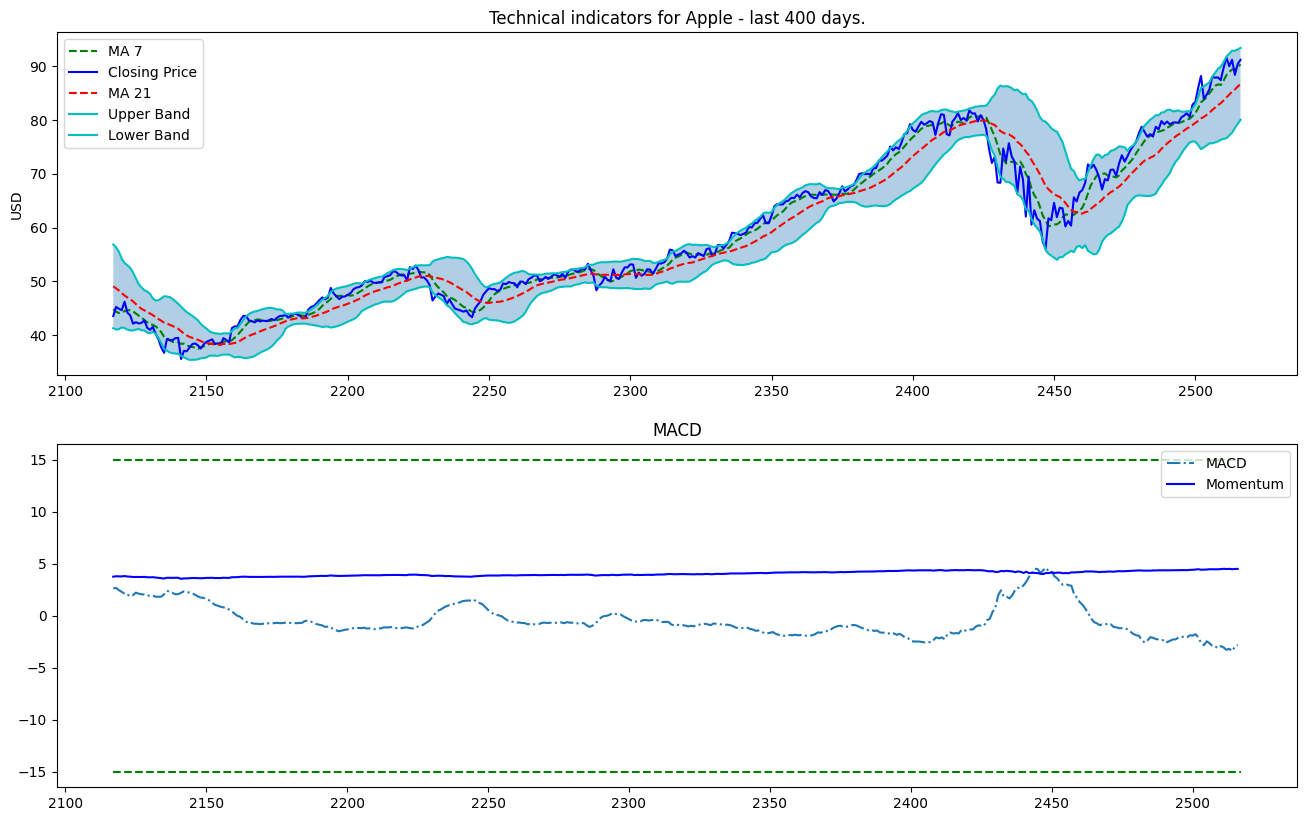

In [8]:
def plot_technical_indicators(dataset, last_days):
    plt.figure(figsize=(16, 10), dpi=100)
    shape_0 = dataset.shape[0]
    xmacd_ = shape_0 - last_days

    dataset = dataset.iloc[-last_days:, :]
    x_ = range(3, dataset.shape[0])
    x_ = list(dataset.index)
     # Plot first subplot
    plt.subplot(2, 1, 1)
    plt.plot(dataset['MA7'], label='MA 7', color='g', linestyle='--')
    plt.plot(dataset['Close'], label='Closing Price', color='b')
    plt.plot(dataset['MA21'], label='MA 21', color='r', linestyle='--')
    plt.plot(dataset['upper_band'], label='Upper Band', color='c')
    plt.plot(dataset['lower_band'], label='Lower Band', color='c')
    plt.fill_between(x_, dataset['lower_band'], dataset['upper_band'], alpha=0.35)
    plt.title('Technical indicators for Apple - last {} days.'.format(last_days))
    plt.ylabel('USD')
    plt.legend()
    plt.subplot(2, 1, 2)
    plt.title('MACD')
    plt.plot(dataset['MACD'], label='MACD', linestyle='-.')
    plt.hlines(15, xmacd_, shape_0, colors='g', linestyles='--')
    plt.hlines(-15, xmacd_, shape_0, colors='g', linestyles='--')
    plt.plot(dataset['logmomentum'], label='Momentum', color='b', linestyle='-')
       
    plt.legend()
    plt.show()

plot_technical_indicators(T_df, 400)


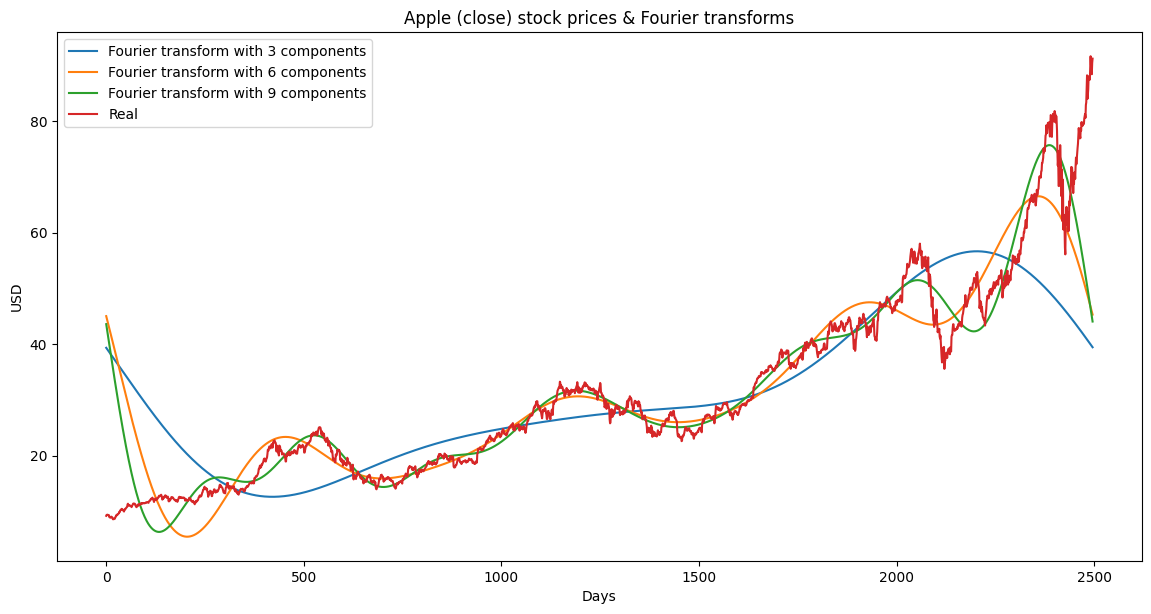

In [9]:
import warnings
warnings.filterwarnings('ignore')
def plot_Fourier(dataset):
    data_FT = dataset[['Date', 'Close']]

    close_fft = np.fft.fft(np.asarray(data_FT['Close'].tolist()))
    fft_df = pd.DataFrame({'fft': close_fft})
    fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
    fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))

    fft_list = np.asarray(fft_df['fft'].tolist())
    plt.figure(figsize=(14, 7), dpi=100)
    fft_list = np.asarray(fft_df['fft'].tolist())
    for num_ in [3, 6, 9]:
        fft_list_m10 = np.copy(fft_list);
        fft_list_m10[num_:-num_] = 0
        plt.plot(np.fft.ifft(fft_list_m10), label='Fourier transform with {} components'.format(num_))
    plt.plot(data_FT['Close'], label='Real')
    plt.xlabel('Days')
    plt.ylabel('USD')
    plt.title('Apple (close) stock prices & Fourier transforms')
    plt.legend()
    plt.show()

plot_Fourier(dataset)
#Footer
